# Import

**Yatipa's data** ([link](https://drive.google.com/drive/u/1/folders/1XXQ9sNsL4cGfNIfuwmVNxZ9UJUUO6Eu9))




*   maker_vat_calls_ethA_2019-2022.csv
*   ethA-dai-price.csv
*   ethA-dai-price2019-2022



In [16]:
import heapq
import pandas as pd
import pickle
from datetime import datetime, timedelta, timezone
from tqdm import tqdm, tqdm_notebook
import bisect
from numpy.polynomial import Polynomial
from scipy import optimize
from scipy.special import binom
import numpy as np
from functools import reduce
import math
from math import pi, exp, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
from mealpy.bio_based import SMA

import cvxpy as cp
import types
from scipy.linalg import cholesky

import warnings
warnings.filterwarnings('ignore')

# Functions

#### Set values and useful functions

In [17]:
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
FLIP_ADDR_1 = '0xd8a04F5412223F513DC55F839574430f5EC15531'
FLIP_ADDR_2 = '0xF32836B9E1f47a0515c6Ec431592D5EbC276407f'
TIME_FACTOR = 60        # minutes

global len_frob_fork_ops_0
len_frob_fork_ops_0 = []

global check 
check = 0

global flag
flag = 'p_or not converge'

#------------------------------------------------------------------------------------------------------------------

def get_utc_timestamp(time):
    return datetime.strptime(str(time), TIME_FORMAT).replace(tzinfo=timezone.utc)
    
#------------------------------------------------------------------------------------------------------------------

def print_ffo():
    global len_frob_fork_ops_0
    return len_frob_fork_ops_0

#### filter_ethA_data

In [18]:
def filter_ethA_data(ethA):
    ethA_filtered = ethA[
        (ethA['fn_name'] == 'grab')
        |
        (
            (ethA['fn_name'] == 'flux')
            &
            (
                (ethA['src'] == FLIP_ADDR_1)
                |
                (ethA['src'] == FLIP_ADDR_2)
            )
        )
        |
        (
            (ethA['fn_name'] == 'frob')
            &
            (ethA['dart'] != 0.0)
        )
        |
        (
            (ethA['fn_name'] == 'fork')
            &
            (ethA['dart'] != 0.0)
        )
    ]

    ethA_filtered = ethA_filtered.astype({ 'rate': 'float' })

    fork_df = ethA_filtered[
        ethA_filtered['fn_name'] == 'fork'
    ]

    def decode(row):
        row['usr'] = row['src']
        row['src'] = None

        row['dart'] = -row['dart']

        return row

    fork_df_inv = fork_df.apply(decode, axis=1)

    return pd.concat([ethA_filtered, fork_df_inv], axis=0).sort_index()

#### cluster_by_ops

In [19]:
## indecies of df should be reseted

def cluster_by_ops(df):
    prev_fn = None

    grab_flux_ops = []
    frob_fork_ops = []
    prev_frob_fork_ops = []

    for index, row in df.iterrows():
        fn = row['fn_name']
        src = row['src']
    
        if fn == 'grab':
            if (prev_fn == 'grab' or prev_fn == 'flux'):
                grab_flux_ops.append(row)
                continue

            if grab_flux_ops:
                yield (prev_frob_fork_ops, grab_flux_ops)

            grab_flux_ops = []
            prev_frob_fork_ops = frob_fork_ops
            frob_fork_ops = []

            grab_flux_ops.append(row)

        elif fn == 'flux':
            grab_flux_ops.append(row)

        else:
            frob_fork_ops.append(row)

        prev_fn = fn


    yield (prev_frob_fork_ops, grab_flux_ops)

    if frob_fork_ops:  # frob_fork_ops not null == true
        yield (frob_fork_ops, [])

#### handle_grab_flux

In [20]:
def handle_grab_flux(grab_flux_ops):
    dink_dai = 0
    flux_dai = 0
    dart_dai = 0
    total_dart = 0

    for row in grab_flux_ops:
        fn_name = row['fn_name']
        time = get_utc_timestamp(row['timestamp']).timestamp()

        if fn_name == 'grab':
            fold_rate = row['rate'] #/ 1e27
            dart = row['dart'] #/ 1e18
            total_dart += dart

            dtab = dart * fold_rate
            dart_dai += -dtab

            dink = -1 * row['dink'] #/ 1e18

            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            dink_dai += (dink * ex_rate_updated)
            # dink_dai += (dink * eth_dai_rate.find_lt(time))

        if fn_name == 'flux':
            wad = row['wad'] #/ 1e18
            # ex_rate = eth_dai_rate.find_lt(time)
            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            flux_dai += (wad * ex_rate_updated)

        
    lgd = (dink_dai - flux_dai) - dart_dai

    return lgd, total_dart

#### handle_frob_fork

In [21]:
def handle_frob_fork(frob_fork_ops):
    total_dart = 0
    prev_time = get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp()
    params = []

    for row in frob_fork_ops:
        time = get_utc_timestamp(row['timestamp']).timestamp()
        dtime = (time - prev_time) / TIME_FACTOR
        prev_time = time

        fold_rate = row['rate'] #/ 1e27
        dart = row['dart'] #/ 1e18

        total_dart += dart

        dtab = dart * fold_rate

        params.append((dtab, dtime))

    return params, total_dart

#### calculate_interest

In [22]:
def calculate_interest(params, init_tab):
    global flag
    def p_or(x):
        total = init_tab
        for dtab, dt in params:
            total = (total * ((1 + x) ** dt) + dtab)

        return total

    def p(F, scale_factor):
        # print('#-------')
        # print(f'\ninit_tab = {init_tab}')
        total = init_tab
        for dtab, dt in params:
            # print(f'dt = {dt}')
            # print(f'dtab = {dtab}')
            dT = dt / scale_factor
            total = (total * (F ** dT) + dtab)

        return total
    # print(params)
    scale_factor = 20.0

    try:
        F = optimize.newton(lambda x: p(x, scale_factor), 1.0, maxiter=1000, tol=1e-10)
#         print(F)
        r = 2 ** (np.log2(F) / scale_factor) - 1
        r_first = r
#         print(r)
    except:
        r = 'Not converge'

    if r!='Not converge':
        p_or_r = p_or(r)
        if abs(p_or_r) > 1e-4:
            scale_factor = 30.0
            try:
                F = optimize.newton(lambda x: p(x, scale_factor), 1.1, maxiter=1000, tol=1e-10)
                r = 2 ** (np.log2(F) / scale_factor) - 1
            except:
                print(flag, params, init_tab)
                # r = 'Not converge p_or'
                r = r_first

    return r

#### split_frob_fork_ops

In [23]:
def split_frob_fork_ops(fork_frob_ops, init_art=0.0):
    def sum(acc, x):
        val = acc[-1] + x[1]['dart']
        acc.append(val)

        return acc
    
    vals = reduce(sum, fork_frob_ops.iterrows(), [0,])     # apply a particular function passed in its argument to all of the list elements
    zeros = np.isclose(vals[1:], 0, atol=10, rtol=0)
    zeros = np.where(zeros == True)
    zeros = [x for x in zeros[0]]
    zeros.append(-1)

    loans = []
    prev_pos = 0
    index = ['usr', 'start', 'end', 'status', 'duration (mins)'] ##, 'interest rate', 'LGD']
    for pos in zeros:
        loan = None
        status = None
        if pos != -1:
            loan = fork_frob_ops.iloc[prev_pos:pos+1]
            status = 'finished'
        else:
            loan = fork_frob_ops.iloc[prev_pos:]
            status = 'active'
            if len(loan) == 0:
                continue

        prev_pos = pos+1

        start = loan.iloc[0]['timestamp']
        end = loan.iloc[-1]['timestamp']
        duration_finished =  (get_utc_timestamp(end).timestamp() - get_utc_timestamp(start).timestamp()) / TIME_FACTOR  
        usr = loan.iloc[0]['usr']
        data = [usr, start, end, status, duration_finished]
        loans.append(pd.Series(data=data, index=index))

    return loans

#### get_results

In [24]:
def get_results(df):
    global len_frob_fork_ops_0
    global check 
    art = 0
    for frob_fork_ops, grab_flux_ops in cluster_by_ops(df):

        # print(len(frob_fork_ops), len(grab_flux_ops))

        if len(frob_fork_ops)==0:
            nums = (0, len(grab_flux_ops))
            len_frob_fork_ops_0.append((nums, df['usr'].iloc[0]))
            continue

        index = ['usr', 'start', 'flag time', 'end', 'status', 'interest rate', 'LGD', 'duration (mins)']
        start = frob_fork_ops[0]['timestamp']
        vault = frob_fork_ops[0]['usr']
        end = None

        if not grab_flux_ops:    # grab_flux_ops = [] --> none
            data = [vault, start, None, end, 'active', None, None, None]
            yield pd.Series(data=data, index=index)
            continue

        init_rate = frob_fork_ops[0]['rate'] 
        init_tab = art * init_rate

        params, dart_ff = handle_frob_fork(frob_fork_ops)
        lgd, dart_gf = handle_grab_flux(grab_flux_ops)

        art += dart_ff
        
        last_time_ff = get_utc_timestamp(frob_fork_ops[-1]['timestamp']).timestamp()
        first_time_gf = get_utc_timestamp(grab_flux_ops[0]['timestamp']).timestamp()
        dtime = (first_time_gf - last_time_ff) / TIME_FACTOR
        flag_time_i = grab_flux_ops[0]['timestamp']

        duration_default = (first_time_gf - get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp())/TIME_FACTOR

        rate = grab_flux_ops[0]['rate'] 
        tab = art * rate

        if init_tab < 0:
            check += 1

        params.append((-(tab + lgd), dtime))
        r = calculate_interest(params, init_tab)
        if type(r) != str:
            if (r < 0)&(lgd > 0):
                print(params)
                print(init_tab)
                print()
                

        end = grab_flux_ops[-1]['timestamp']

        data = [vault, start, flag_time_i, end, 'default', r, lgd, duration_default]
        yield pd.Series(data=data, index=index)

        art += dart_gf


# Data Pre-processing

## vat_E

In [25]:
def get_utc_time(time, format_t):
    t_ime = datetime.strptime(str(time), format_t).replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp() 
    return time_a

def to_date(time, format_t):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime(format_t)

In [26]:
# vat_E_pam = pd.read_csv('/content/drive/MyDrive/1_thesis/old_data/maker_vat_calls_ethA_2019-2022.csv').drop(columns=['Unnamed: 0','state','Unnamed: 0.1'])
# vat_E_pam = vat_E_pam[vat_E_pam['usr'].notna()] 
# vat_E_pam['dart'] = vat_E_pam['dart'] / 1e18
# vat_E_pam['dink'] = vat_E_pam['dink'] / 1e18
# vat_E_pam['wad'] = vat_E_pam['wad'] / 1e18
# vat_E_pam['rate']  = vat_E_pam['rate'].astype({ 'rate': 'float' })
# vat_E_pam['rate'] =vat_E_pam['rate'] / 1e27
# vat_E_pam = vat_E_pam.drop_duplicates()
# vat_E_pam['time_f'] = vat_E_pam['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S UTC'))
# vat_E_pam['timestamp'] = vat_E_pam['time_f'].apply(lambda x: to_date(x, '%Y-%m-%d %H:%M:%S'))
# vat_E_pam = vat_E_pam.sort_values(by='timestamp')
# vat_E_pam = vat_E_pam.reset_index(drop=True)

In [27]:
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/MakerDao_data_2019_2023_latest_update.csv').drop(columns=['Unnamed: 0', 'state'])
print(vat_E.shape)
vat_E.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/1_thesis/1_working/data_final/MakerDao_data_2019_2023_latest_update.csv'

In [ ]:
vat_E = vat_E[vat_E['usr'].notna()] 
vat_E['dart'] = vat_E['dart'] / 1e18
vat_E['dink'] = vat_E['dink'] / 1e18
vat_E['wad'] = vat_E['wad'] / 1e18
vat_E['rate'] = vat_E['rate'].astype({ 'rate': 'float' })
vat_E['rate'] = vat_E['rate'] / 1e27
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

print(f'vat_E shape : {vat_E.shape}')

In [ ]:
vat_E[vat_E.duplicated(keep=False)]

In [ ]:
# vat_E = vat_E.drop_duplicates()
# print(f'vat_E shape after drop duplicate: {vat_E.shape}')

vat_E['time_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S'))

# vat_E = vat_E.reset_index(drop=True)
vat_E.head(3)

In [ ]:
vat_E

In [ ]:
# print(min(vat_E_pam['timestamp']), max(vat_E_pam['timestamp']))
print(min(vat_E['timestamp']), max(vat_E['timestamp']))

In [ ]:
# vat_E_pam.describe()

In [ ]:
vat_E.describe()

In [ ]:
print(max(vat_E.isnull().sum(axis=1)))

null_data = {'src': [vat_E['src'].isnull().sum()], 
             'dart': [vat_E['dart'].isnull().sum()],
             'dink': [vat_E['dink'].isnull().sum()],
             'wad':  [vat_E['wad'].isnull().sum()],
             'sum': [sum(vat_E.isnull().sum(axis=1))]
            }
df_null = pd.DataFrame(data = null_data, index = ['data'])
df_null

In [ ]:
def to_date(date_t):
  datetime_obj = datetime.strptime(str(date_t), '%Y-%m-%d %H:%M:%S')
  date_i = datetime_obj.date()
  return date_i

df_beer = vat_E.copy()
# df_pam = vat_E_pam.copy()

df_beer['date'] = df_beer['timestamp'].apply(lambda x: to_date(x))
# df_pam['date'] = df_pam['timestamp'].apply(lambda x: to_date(x))

In [ ]:
data_b = df_beer['date'].value_counts()
data_b = pd.DataFrame(data_b)
data_b = data_b.reset_index()
data_b = data_b.rename({'date':'count', 'index': 'date'}, axis=1) 
data_b = data_b.sort_values(by='date')
data_b = data_b.reset_index(drop=True)
data_b          # updated day == 1235 - 2 days

In [ ]:
# check days -->  1176 days --> correct!
(data_b['date'][1173] - data_b['date'][0]).days  + 1

In [ ]:
# data_p = df_pam['date'].value_counts()
# data_p = pd.DataFrame(data_p)
# data_p = data_p.reset_index()
# data_p = data_p.rename({'date':'count', 'index': 'date'}, axis=1) 
# data_p = data_p.sort_values(by='date')
# data_p = data_p.reset_index(drop=True)
# data_p

In [ ]:
vat_E.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv')

## daieth2

In [ ]:
def get_utc_time(time):
    t_ime = datetime.strptime(str(time), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp() 
    return time_a

def to_date(time):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime('%Y-%m-%d %H:%M:%S')

def find_lt(data):
    i = bisect.bisect_left(daieth_rate['timestamp_f'], data)
    return daieth_rate['dai/eth'][i-1]

In [ ]:
# -------------- file from Yatipa ----------------
eth_dai_rates = None
file_name = '/content/drive/MyDrive/1_thesis/old_data/ethA-dai-price.csv'
with open(file_name, 'rb+') as f:
    eth_dai_rates = pickle.load(f)

eth_dai = pd.DataFrame(eth_dai_rates, columns=['timestamp_f', 'dai/eth'])
eth_dai['dai/eth'] = eth_dai['dai/eth'].astype({ 'dai/eth': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp_f'].apply(lambda x: to_date(x))
eth_dai['timestamp_f'] = eth_dai['timestamp_f'].astype({ 'timestamp_f': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp'].astype({ 'timestamp': 'datetime64' })

eth_dai = eth_dai.sort_values('timestamp')
eth_dai = eth_dai.reset_index(drop=True)
print(min(eth_dai.timestamp))
print(max(eth_dai.timestamp))
eth_dai

In [ ]:
# Rate should be --> 'eth_dai' 
daieth_rate = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/dai_eth_rate_update.csv').drop(columns=['Unnamed: 0'])
daieth_rate = daieth_rate.drop('dai_eth', axis=1)
daieth_rate['timestamp'] = daieth_rate['timestamp'].astype({ 'timestamp': 'datetime64' })
daieth_rate['timestamp_f'] = daieth_rate['timestamp'].apply(lambda x: get_utc_time(x))
daieth_rate = daieth_rate.rename(columns={"eth_dai": "dai/eth"})
daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)
daieth_rate.head(2)

In [ ]:
daieth_rate.tail(2)

In [ ]:
# Append data from Yatipa (date before 2019-11-15 05:05:14 	)
df = eth_dai[eth_dai['timestamp'] <= daieth_rate['timestamp'][0]]
daieth_rate = pd.concat([df, daieth_rate])

daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)

print(max(daieth_rate.timestamp))
daieth_rate

In [ ]:
df.shape[0]

In [ ]:
daieth_rate[:793]

In [ ]:
daieth_rate[368:380]

In [ ]:
eth_dai_rate_list = []

for i in tqdm(range(len(vat_E['timestamp']))):
    time = get_utc_time(vat_E['timestamp'][i])
    ex_r = find_lt(time)
    eth_dai_rate_list.append(ex_r)     

list_time = list(vat_E['timestamp'])
daieth_rate_pd = pd.DataFrame(list(zip(list_time, eth_dai_rate_list)),columns =['timestamp', 'dai/eth'])
daieth_rate_pd

In [ ]:
daieth2 = daieth_rate_pd.copy() 
daieth2 = daieth2.drop_duplicates(subset=['timestamp'])
daieth2["timestamp"] = daieth2["timestamp"].astype("datetime64")
daieth2['timestamp_f'] = daieth2['timestamp'].apply(lambda x: get_utc_time(x))
daieth2 = daieth2.sort_values('timestamp')
daieth2 = daieth2.reset_index(drop=True)

print(daieth2.shape)
daieth2.head(3)

In [ ]:
daieth2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv')

## Stability fee

In [ ]:
vat_E['timestamp_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x))

sf_ethA = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/stability_fee_ethA.csv').drop('Unnamed: 0', axis=1)

# map stability fee to vat_E's timestamp
sf_ethA["timestamp"] = sf_ethA["timestamp"].astype("datetime64")
sf_ethA['timestamp_f'] = sf_ethA['timestamp'].apply(lambda x: get_utc_time(x))

sf_rate_list = []
vat_E_time = list(vat_E['timestamp'])
vat_E_time_float = list(vat_E['timestamp_f'])

for i in tqdm(range(len(vat_E_time_float))):
    time = vat_E_time_float[i]
    bisc = bisect.bisect_left(sf_ethA['timestamp_f'], time)
    idx = bisc - 1
    sf_rate = sf_ethA['rate_year'][idx]         
    sf_rate_list.append(sf_rate)

sf_rate_pd = pd.DataFrame(list(zip(vat_E_time, vat_E_time_float, sf_rate_list)), columns = ['timestamp', 'timestamp_f', 'sf_rate'])
sf_rate_pd = sf_rate_pd.drop_duplicates(subset=['timestamp'])
sf_rate_pd = sf_rate_pd.reset_index(drop=True)

In [ ]:
sf_rate_pd.head(3)

In [ ]:
sf_rate_pd.tail(3)

In [ ]:
sf_rate_pd.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv')

## loans - active

get credits of users who weren't liquidated

In [ ]:
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp' : 'datetime64' })

daieth2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp' : 'datetime64' })

sf_rate_pd = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp' : 'datetime64' })

In [ ]:
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)

grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())
other_usr = set(grouped.groups.keys()) - grab_usr

#----------------------------------------------------------------------------------------------------------------

# # get credits of users who weren't liquidated
# loans_all = []
# for v in tqdm(other_usr):
#     v_gr = grouped.get_group(v)
#     loans = split_frob_fork_ops(v_gr)
#     loans_all.extend(loans)

# loans_all = pd.DataFrame(loans_all)
# loans_all.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_active')
# # loans_all

#----------------------------------------------------------------------------------------------------------------

loans_all = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_active.csv').drop(columns=['Unnamed: 0'])
loans_all['start'] = loans_all['start'].astype({ 'start' : 'datetime64' })
loans_all['end'] = loans_all['end'].astype({ 'end' : 'datetime64' })

print(loans_all.shape)
loans_all.head(3)

## loans - liquidate

get credits of users who were **liquidated** at least once!

In [ ]:
stat = []

# get credits of users who were liquidated at least once
for vault in tqdm(grab_usr):
    group = grouped.get_group(vault)

    stat.extend(
        [row for row in get_results(group)]
    )

# print --> params and initial tab

In [ ]:
grouped.get_group(list(grab_usr)[68])

Check fault case in cluster grab flux!

There were some wierd case occured because of using sort_values by timestamp.

Don't sort! Already check datetime all.

In [ ]:
ffo_no_data = print_ffo()
ffo_no_data

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

In [ ]:
# ffo_no_data = print_ffo()

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

In [ ]:
# all_fn_inside = []

# for user in prob_usr:
#     data = grouped.get_group(user)
#     all_fn_inside.append(str(data['fn_name'].values))

# ds = {'prob_usr': prob_usr, 'all_fn': all_fn_inside}
# pd_fn_prob = pd.DataFrame(data=ds)
# pd_fn_prob

In [ ]:
loans = pd.DataFrame(stat)
loans[loans['LGD'] < 0.0].shape

In [ ]:
loans['usr'].nunique()

In [ ]:
loans['status'].unique()

In [ ]:
loans = loans[loans['LGD'] > 0.0]

In [ ]:
loans

In [ ]:
loans[loans['interest rate']=='Not converge']

In [ ]:
loans[loans['interest rate']=='Not converge p_or'].shape[0]

In [ ]:
loans.describe()

In [ ]:
# loans[loans['interest rate']=='Not converge p_or']

In [ ]:
# loans = loans[loans['interest rate'] != 'Not converge p_or']
# loans['interest rate'] = loans['interest rate'].astype('float')
# loans.describe()

In [ ]:
loans[loans['interest rate'] < 0]

In [ ]:
loans[loans['interest rate'] == 0]

In [ ]:
loans_2 = loans.copy()

In [ ]:
loans_2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_liquidate.csv')

## get stat

In [ ]:
list_usr = list(set(grouped.groups.keys()))
df_usr_isin = vat_E[vat_E.usr.isin(list_usr)]
tot_dai = df_usr_isin.dart.sum()
tot_eth = df_usr_isin.dink.sum()
tot_usr = len(set(grouped.groups.keys()))
tot_loan = loans.shape[0] + loans_all.shape[0]

print(f"totoal usr: {tot_usr}\ntotal number of loan: {tot_loan}\ntotal locked collateral: {tot_eth} ETH\ntotal generated debt: {tot_dai} DAI")

s = pd.to_datetime(loans.start)
credit_d_count = pd.DataFrame(s.groupby(s.dt.floor('d')).size().reset_index(name='count'))
pd.to_numeric(credit_d_count['count']).mean()

print(f"the average daily loan: {pd.to_numeric(credit_d_count['count']).mean()} loans")

In [ ]:
total_locked_collateral = tot_eth * 1985.66     # Last update: 12:51 PM, April 13, 2023
total_locked_collateral

In [ ]:
231518562.12 / 421276896.85

In [ ]:
# overall lambda (when consider the whole loan during 2019-2023)
loans_dura_min = loans['duration (mins)'].sum()
loans_all_dura_min = loans_all['duration (mins)'].sum()
p = (loans.shape[0] + loans_all.shape[0]) / (loans_dura_min + loans_all_dura_min)
t_p = (1/p)/(60*24)
print(f"the mean time until default: {t_p} days")

## Daily variance of each asset (loan) --> sigma


- $a(t)$ be the amount of collateralized assets (ETH/ ink)
- $d(t)$ be debt at time $t$. (DAI/ tab)
- $e(t)$ the exchange rate of the collateral asset to debt asset and $e(0) =e_0$
- $r(t)$ the collateralized ratio for $d(t) > 0$ 
- If $d(t) = 0$ we can set $r(t) = +\infty$.  

- $ \hat \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N \left(\ln \left(\frac{e(t_n)}{e(t_{n-1})}\right)\right)^2/(t_n - t_{n-1})} $

-  $x_{\min} = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right)$ by Brownian motion  $\texttt{B}_t$
-  $x_{\min}(t) = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right) + ft = x_{\min} + ft$
- $\psi(x_{min}) = P\left(T_{x_{\min }, f}<T\right)=\int_{0}^{T} \frac{-x_{\min }-f t}{\sqrt{2 \pi s^{3}}} e^{-\frac{\left(x_{\min }+f t\right)^{2}}{2 s}} d s .$
- $\texttt{var} = \psi(x_{\min}) \cdot (1 - \psi(x_{\min}))$ 

In [ ]:
daieth2 = daieth2.reset_index(drop=True)
tot_l = 0
for index, row in tqdm(daieth2[1:].iterrows()): 
    n = daieth2.loc[index,'timestamp']  
    n_1 = daieth2.loc[index-1,'timestamp']  
    tot_l += (math.log(daieth2.loc[index,'dai/eth']/daieth2.loc[index-1,'dai/eth']))**2/((n-n_1).total_seconds()/(60*60)) # s -> h
sigma = sqrt(tot_l/daieth2.shape[0]) 

In [ ]:
sigma

## vat_E2

In [ ]:
# vat_E2 = vat_E.copy()

# for index, row in tqdm_notebook(vat_E2.iterrows()): 
#     time = row['timestamp']
#     dink = 1 * row['dink'] 
#     ex_rate_row = daieth2[daieth2['timestamp'] >= time]['dai/eth'].iloc[0]
#     vat_E2.at[index, 'ex_rate'] =  ex_rate_row
#     vat_E2.at[index, 'dink_dai'] = (dink * ex_rate_row)  

# vat_E2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv')

vat_E2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv').drop(columns=['Unnamed: 0'])
vat_E2.head()

## Check again! --> Liquidation table

In [ ]:
def pid(df_name,usr_id):
    return df_name.loc[df_name['usr'] == usr_id]

def get_utc_timestamp(time):
    time_str = str(time)
    t_ime = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp() 
    return time_a

def get_stability_fee(t):
    time = get_utc_timestamp(t)
    ra_te = sf_rate_pd[sf_rate_pd['timestamp_f'] >= time]['sf_rate'].iloc[0]
    sf = (ra_te) ** (1/(365*24)) - 1    # y -> h
    return sf

def get_collteral_ratio(t):
    date_change = '2021-08-27 18:04:23'
    time_ch = get_utc_timestamp(date_change)
    time = get_utc_timestamp(t)

    if time < time_ch:
      col_rate = 1.5
    else:
      col_rate = 1.45
    return col_rate

# psi(Xmin)
def f(s, xm, t):
    sf = get_stability_fee(t)
    return -(xm + sf * s) / sqrt(2 * pi * s ** 3) * exp(- (xm + sf * s) ** 2 / ( 2 * s))

def table_liq(usr_id):
    '''Collect total debt, collateral, collateral ratio, etc.'''
    dx = pid(vat_E2, usr_id).drop(columns = ['ilk']).reset_index(drop=True)
    dx_l = dx.drop(columns = ['dink']) 
    dx_l['dtab'] = dx_l['dart'] * dx_l['rate']
    dx_l['art'] = dx_l['dart'].cumsum()
    dx_l['ink'] = dx_l['dink_dai'].cumsum()  
    g = dx_l['fn_name'].eq("grab").shift().bfill().cumsum() 
    dx_l['tab'] = dx_l.groupby(g)['dtab'].cumsum()

    dx_l['collateral ratio'] = 100 * dx_l['ink'] / dx_l['tab'] 
    dx_l['collateral ratio'] = dx_l['collateral ratio'].replace([np.inf, -np.inf], np.nan) 
    columns_titles = ['usr','fn_name','timestamp','dart', "dink_dai",'dtab',"wad",'art', 'ink', 'tab','ex_rate',"rate", "collateral ratio"]
    dx_l = dx_l.reindex(columns=columns_titles)
    return dx_l

######################################################################################################################################################################

liq_df = pd.DataFrame( )
for vault in tqdm_notebook(grab_usr):
    '''KEEP THE LAST TIMESTAMP OF EACH DAY'''
    a = table_liq(vault)
    a["timestamp"] = a["timestamp"].astype("datetime64") 
    a['tab_at_mn'] = a['tab']
    a['x_min'] = None
    a = a.groupby(a.timestamp.dt.date).last().reset_index(drop=True)

    for index, row in a.iterrows(): 
        date='year/month/day 23:59:59'
        midnight_date = date.replace('year', str(row.timestamp.year)).replace('month', str(row.timestamp.month)).replace('day', str(row.timestamp.day))
        time_diff = (pd.to_datetime(midnight_date, format='%Y/%m/%d %H:%M:%S') - row.timestamp).total_seconds()/(60*60) # second -> hr

        # art with stability fee
        sf_t = get_stability_fee(row.timestamp)  
        a.at[index, 'tab_at_mn'] = row.tab * (exp(sf_t * time_diff))

        # x min
        r_min = get_collteral_ratio(row.timestamp) 
        if row['ink']!= 0:
            a.at[index, 'x_min'] = np.log((row['tab_at_mn'] * r_min)/(row['ink'])) / sigma + sf_t*(24) # 1 day -> hr  # del * row['ex_rate'] due to ink in DAI already
        else:
            a.at[index, 'x_min'] = np.inf  

        # psi & var
        if a.at[index,'x_min'] <= 0:
            psi = quad(f, 0, (24), args = (a.at[index, 'x_min'], row.timestamp))[0] # day -> hr  
            a.at[index,'psi'] = psi  
            a.at[index,'var'] = psi * (1 - psi) 
        else:  
            a.at[index,'psi'] = None  
            a.at[index,'var'] = None

    liq_df = liq_df.append(a, ignore_index=True)
    liq_df = liq_df[liq_df['tab_at_mn']>0]
    

In [ ]:
liq_df2 = liq_df.copy()
liq_df2["timestamp"] = liq_df2["timestamp"].astype("datetime64").dt.date 

a = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])]
liq_df2 = a[~a['x_min'].isnull() & ~a['psi'].isnull()]
liq_df2

In [ ]:
# Start

In [29]:
liq_df2.to_csv('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/Data/liq_df2.csv')

NameError: name 'liq_df2' is not defined

In [34]:
liq_df2 = pd.read_csv('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/Data/liq_df2.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })
liq_df2

usr fn_name  timestamp  \
0      0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD    frob 2021-03-19   
1      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-19   
2      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-20   
3      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-07-14   
4      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-08-02   
...                                           ...     ...        ...   
19929  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-10-24   
19930  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-03   
19931  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-04   
19932  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-05   
19933  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-13   

               dart      dink_dai          dtab  wad            art  \
0       3289.016182   9127.730971   3400.000000  NaN    3289.016182   
1      10320.268294  16871.358633  10327.046576  NaN   13969.165199   
2       1056.064209   1741.857305   1056.768596  NaN   18554.762148   
3       9520.766397  19437.900000  10000.000000  NaN    9520.766397   
4          0.000000   4966.562385      0.000000  NaN   14275.507941   
...             ...           ...           ...  ...            ...   
19929  13705.023155      0.000000  14000.000000  NaN  198947.750086   
19930 -44832.216388      0.000000 -45820.000000  NaN  154115.533698   
19931  29351.081275      0.000000  30000.000000  NaN  183466.614973   
19932   7826.719133      0.000000   8000.000000  NaN  191293.334105   
19933  -5000.102257      0.000000  -5113.000000  NaN  186293.231848   

                 ink            tab      ex_rate      rate  collateral ratio  \
0        9127.730971    3400.000000  1825.546194  1.033744        268.462676   
1       22836.567671   13978.295917   173.775000  1.000657        163.371614   
2       30399.759876   18566.940504   175.321400  1.000667        163.730583   
3       19437.900000   10000.000000  1943.790000  1.050336        194.379000   
4       24404.462385   15000.000000  2612.700000  1.051582        162.696416   
...              ...            ...          ...       ...               ...   
19929  327915.077541  203000.010000   410.090000  1.021523        161.534513   
19930  327915.077541  157180.010000   374.020000  1.022033        208.623907   
19931  327915.077541  187180.010000   381.650000  1.022109        175.187018   
19932  327915.077541  195180.010000   404.740000  1.022140        168.006487   
19933  327915.077541  190067.010000   463.800000  1.022579        172.526036   

           tab_at_mn      x_min           psi           var  
0        3400.108708 -29.498219  1.730533e-09  1.730533e-09  
1       13978.370862  -4.327380  3.770647e-01  2.348869e-01  
2       18568.843818  -4.438609  3.649243e-01  2.317545e-01  
3       10000.438864 -13.134305  7.339957e-03  7.286082e-03  
4       15000.563940  -4.117553  4.006339e-01  2.401264e-01  
...              ...        ...           ...           ...  
19929  203000.342955  -3.754337  4.434686e-01  2.468042e-01  
19930  157187.041690 -16.718446  6.433950e-04  6.429810e-04  
19931  187184.754457  -7.866093  1.083501e-01  9.661039e-02  
19932  195189.664606  -5.745152  2.409082e-01  1.828715e-01  
19933  190077.201830  -7.090423  1.478071e-01  1.259602e-01  

[19934 rows x 17 columns]

In [35]:
liq_df2.describe()

dart      dink_dai          dtab         wad           art  \
count  1.993400e+04  1.993400e+04  1.993400e+04   95.000000  1.993400e+04   
mean   1.736765e+03  1.072832e+04  1.725012e+03   20.321553  1.157512e+05   
std    1.658724e+05  1.628125e+05  1.769351e+05   66.679347  1.000918e+06   
min   -1.538693e+07 -4.922910e+06 -1.650000e+07    0.000406 -1.955414e-11   
25%    0.000000e+00  0.000000e+00  0.000000e+00    0.105964  9.923277e+02   
50%    0.000000e+00  0.000000e+00  0.000000e+00    1.575367  7.008354e+03   
75%    2.997151e+02  1.184175e+03  3.004196e+02    8.446485  3.067002e+04   
max    5.699488e+06  9.261017e+06  6.005400e+06  549.288425  6.457578e+07   

                ink           tab       ex_rate          rate  \
count  1.993400e+04  1.993400e+04  19934.000000  19934.000000   
mean   2.261031e+05  9.272188e+04    939.434614      1.026251   
std    1.430773e+06  5.790532e+05   1157.865741      0.019611   
min    2.286358e-01  3.552714e-15    100.360000      1.000519   
25%    2.515897e+03  1.000000e+03    182.063616      1.013564   
50%    1.649679e+04  6.958292e+03    247.210000      1.019999   
75%    7.324140e+04  3.074078e+04   1676.972671      1.035367   
max    8.889400e+07  3.726990e+07   4844.980000      1.086940   

       collateral ratio     tab_at_mn         x_min           psi  \
count      1.993400e+04  1.993400e+04  19934.000000  1.993400e+04   
mean       3.529291e+15  9.272539e+04    -28.174145  1.007996e-01   
std        3.437492e+17  5.790669e+05     72.236044  2.192554e-01   
min        1.450815e+02  3.552714e-15  -2042.417977 -1.768874e-03   
25%        1.802425e+02  1.000028e+03    -31.993811  6.201091e-11   
50%        2.176477e+02  6.958772e+03    -19.066367  9.786346e-05   
75%        2.800807e+02  3.074200e+04     -9.498393  5.183379e-02   
max        4.775685e+19  3.726995e+07     -0.000051  9.984898e-01   

                var  
count  1.993400e+04  
mean   4.256852e-02  
std    7.656244e-02  
min   -1.772002e-03  
25%    6.201091e-11  
50%    9.785389e-05  
75%    4.397538e-02  
max    2.499999e-01

In [36]:
liq_df2.shape[0], liq_df2[liq_df2['x_min'] > 0 ].shape[0],

(19934, 0)

In [37]:
# check x_min < 0 NaN
len(liq_df2[liq_df2['x_min'] > 0]),len(liq_df2[liq_df2['x_min'].isnull()]),len(liq_df2[liq_df2['psi'].isnull()]),len(liq_df2[liq_df2['var'].isnull()])

(0, 0, 0, 0)

scale of x_min (-2042.4179765987424,-5.060236935132173e-05)


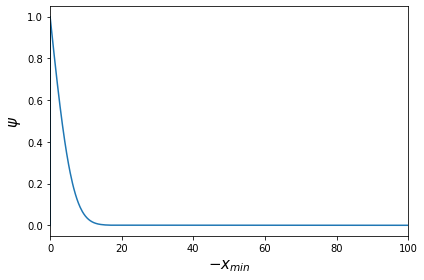

In [38]:
# plot psi x_min 
n_inf_x_min = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])].sort_values(by=['x_min'])
print(f"scale of x_min ({n_inf_x_min['x_min'].min()},{n_inf_x_min['x_min'].max()})")
plt.plot(list(-n_inf_x_min["x_min"]),list( n_inf_x_min["psi"]))
plt.xlabel(r'$-x_{min}$',size = 15)
plt.ylabel(r"$\psi$",size = 15)
# plt.grid(True)
plt.xlim((0,100))
plt.tight_layout()
plt.show()

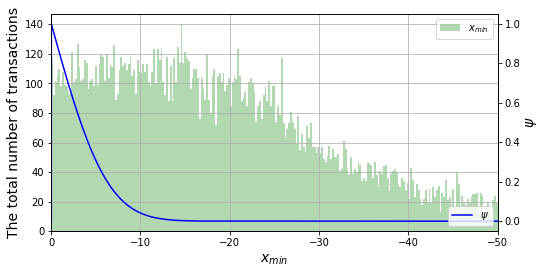

In [39]:
fig, ax1 = plt.subplots(1,1,  figsize=(8,4) )
n_inf_x_min['x_min'].hist(ax=ax1, bins=10000, color='green',alpha = 0.3, label = r'$x_{min}$')
ax2 = ax1.twinx()
n_inf_x_min.plot.line(ax=ax2,x='x_min', y='psi', color='blue', label = r'$\psi$')
ax1.set_xlim((0,-50)) 
ax2.set_xlim((0,-50)) 

ax2.set_ylabel(r'$\psi$', fontsize=14) # from theory 
ax1.set_ylabel(r'The total number of transactions', fontsize=14) # from actual data
ax1.set_xlabel(r'$x_{min}$', fontsize=14) 
locs = ["upper right", "lower right"]
ax1.legend(loc=locs[0])
ax2.legend(loc=locs[1])
plt.show()

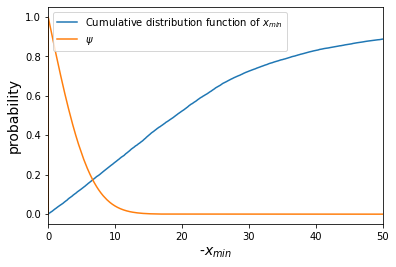

In [40]:
#sort data
data=list(n_inf_x_min['x_min'])
data = [-x for x in data]
x = np.sort(data)

#calculate CDF values
y = 1. * np.arange(len(data)) / (len(data) - 1)

#plot CDF
plt.plot(x, y, label = r'Cumulative distribution function of $x_{min}$')
plt.plot(list(-n_inf_x_min["x_min"]),list( n_inf_x_min["psi"]), label = r'$\psi$')
plt.xlabel(r'$-x_{min}$',size = 14)
plt.ylabel("probability",size = 14)
plt.xlim(-0.01,50)
plt.xlabel(r'-$x_{min}$')
plt.legend()
plt.show()

In [41]:
n_inf_x_min["psi"]

16305    0.000000
18134    0.000000
4204     0.000000
4200     0.000000
4197     0.000000
           ...   
16716   -0.000142
299     -0.000122
14256   -0.000078
1530    -0.000012
5276    -0.000008
Name: psi, Length: 19934, dtype: float64

In [44]:
daieth2 = pd.read_csv('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/Data/daieth2.csv')

In [46]:
vat_E = pd.read_csv('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/Data/MakerDao_data_2019_2023_latest_update.csv').drop(columns=['Unnamed: 0', 'state'])

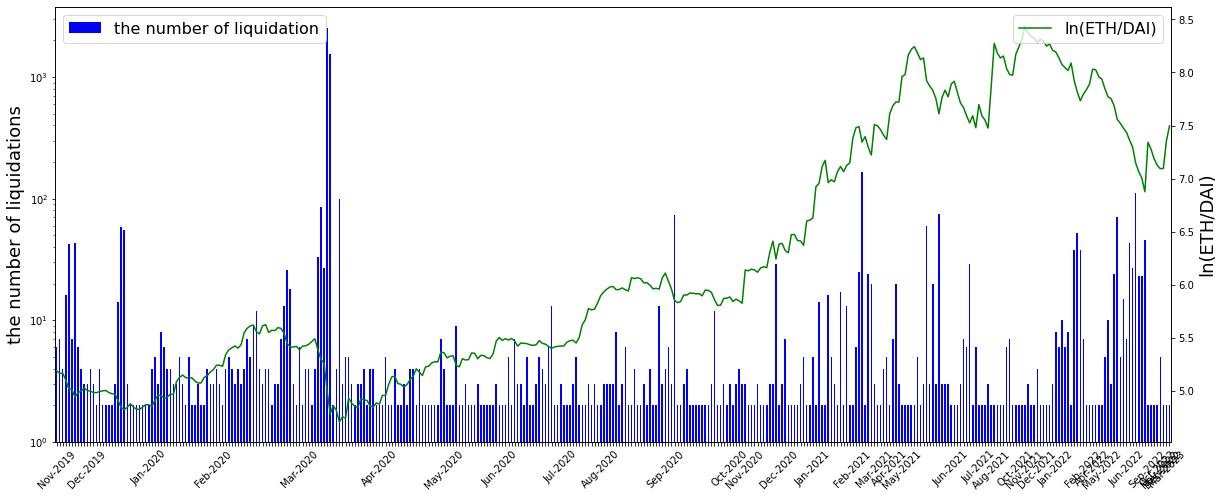

In [47]:
# both y axis are in log
daieth_gp = daieth2.copy()  
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date 
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j
    
###################################################

fig, ax1 = plt.subplots(1,1,figsize=(20, 8)) 
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'the number of liquidation')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)') 

ax1.set_ylabel('the number of liquidations', fontsize=18) 
ax2.set_ylabel('ln(ETH/DAI)', fontsize=18) 

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10) 
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10) 

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)
plt.show()


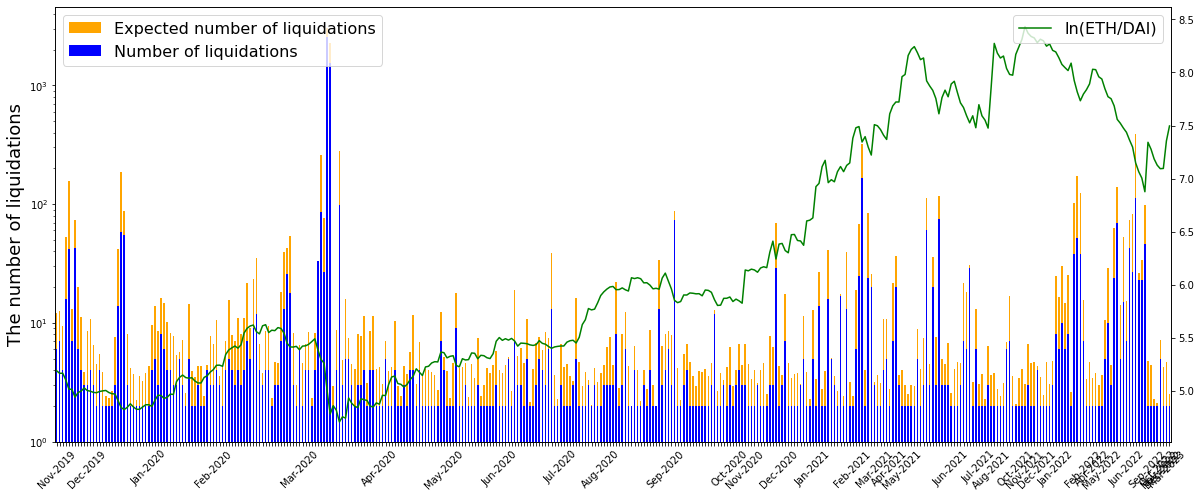

In [60]:
# both y axis are in log
import random
daieth_gp = daieth2.copy()
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j

###################################################

fig, ax1 = plt.subplots(1,1,figsize=(20, 8))
merge_df['Count_pred'] = merge_df['Count'].apply(multiply_func)

merge_df['Count_pred'].plot(ax=ax1, color='orange',kind='bar',log=True, label = 'Expected number of liquidations')
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'Number of liquidations')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)')

ax1.set_ylabel('The number of liquidations', fontsize=18)

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10)
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10)

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)

plt.savefig('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/bm.png')

plt.show()


In [ ]:
abs(liq_df2.timestamp.min()-liq_df2.timestamp.max()).days

In [ ]:
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp') 

In [ ]:
df_count

# Optimization

objective function: $$  \|\vec{a}\|_1 \rightarrow max \,\, \vec{a}$$

constraints:
$$
\begin{gathered}
\vec{a}^{T} K \vec{a} \leq \sigma^{2} \cdot\|\vec{a}\|_{1}^{2} \\
\overrightarrow{0} \leq \vec{a} \leq \vec{A}
\end{gathered}
$$

In [ ]:
# ---------- read all data ---------- 
# vat_E
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

# ETH/DAI rate
daieth2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp': 'datetime64' })

# stability fee rate
sf_rate_pd = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp': 'datetime64' })

# see shape
print(f'vat_E shape = {vat_E.shape} \ndaieth2 shape = {daieth2.shape} \nsf_rate_pd shape = {sf_rate_pd.shape}')

# group grab users
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)
grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())

# liq_df2
liq_df2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/liq_df2.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })

# df_count
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp') 

# see liq_df2
liq_df2.head(2)

In [ ]:
# from Forex data
sigma2 = 0.00198/1.27   
sigma = np.sqrt(sigma2)

# All timestamps
duration_date = sorted(list(liq_df2['timestamp'].unique()))

print(f'All days = {len(duration_date)} \nfrom {min(duration_date)} to {max(duration_date)}')

## SOCP

Find nearest SPD ([link](https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd))

In [ ]:
len(duration_date)

In [ ]:
mtx_K = {}
for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)
    mtx_K[day_idx] = K

In [ ]:
mtx_K[duration_date[9]]

In [ ]:
# pd_L = {}
spd_K = {}
for date, K in mtx_K.items():
    try:
        L = np.linalg.cholesky(K)
        # pd_L[date] = L
    except:
        spd_K[date] = K

In [ ]:
len(spd_K)

In [ ]:
spd_date = []
for date, K in spd_K.items():
    spd_date.append(date)
len(spd_date)



---



In [ ]:
day_idx = duration_date[5]
mtx = mtx_K[day_idx]
lmbd, U = np.linalg.eig(mtx)
lmbd

In [ ]:
diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
diag_lmbd[1]

In [ ]:
U_lamb = np.dot(U, diag_lmbd)
vec = np.dot(U_lamb, U_lamb.T)
mat_mul = U_lamb @ U_lamb.T
print(np.linalg.norm(mtx-vec, ord='fro'), np.linalg.norm(mtx-mat_mul, ord='fro') )

In [ ]:
# table = liq_df2[liq_df2["timestamp"] == day_idx]
table = liq_df2[liq_df2["psi"] < 0]
table[['timestamp', 'psi', 'x_min']]

In [ ]:
table = liq_df2[((liq_df2["x_min"] < 0) & (liq_df2["psi"] < 0))]
table[['timestamp', 'psi', 'x_min']]



---



In [ ]:
norm_control = []
all_L = []
for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i, (p_A, x_A) in enumerate(zip(list(table['psi']), list(table['x_min']))):
        for j, (p_B, x_B) in enumerate(zip(list(table['psi']), list(table['x_min']))):
            K[i, j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)

    # symmetric
    K = 1/2 * (K + K.T)

    # Adjust K if K isn't PD
    try: 
        L = np.linalg.cholesky(K)
    except:
        lmbd, U = np.linalg.eig(K)
        diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
        L = np.dot(U, diag_lmbd)
        vec = np.dot(L, L.T)
        mat_mul = L @ L.T
        norm_control.append((np.linalg.norm(K - vec, ord='fro'), np.linalg.norm(K - mat_mul, ord='fro')))
    all_L.append(L)

In [ ]:
len(norm_control)

In [ ]:
K_not_pos_def = []
validate_to_pd = []

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # symmetric
    K = 1/2*(K + K.T)

    # Adjust K if K isn't PD
    try: 
        L = np.linalg.cholesky(K)
    except:
        (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
        try:
            L = np.linalg.cholesky(K)
        except:
            K_not_pos_def.append(K)
            validate_to_pd.append(day_idx)
            continue
        


In [ ]:
len(K_not_pos_def)

In [ ]:
len(validate_to_pd)

In [ ]:
validate_to_pd

## optimization

In [ ]:
def margine(vector_a, sigma2, covariance_matrix):
    return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - ((vector_a @ covariance_matrix) @ vector_a)   

def ub_constraint(vector_a, A):
    return cp.sum(vector_a) - cp.sum(A) 

def validate_positive_definitive(M):
    M = (M + M.T) * 0.5
    k = 0
    I = np.eye(M.shape[0])
    while True:
        try:
            _ = np.linalg.cholesky(M)
            break
        except np.linalg.LinAlgError:            
            k += 1
            w, v = np.linalg.eig(M)
            min_eig = v.min()

            if isinstance(min_eig, complex):
              min_eig = float(min_eig)
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())
            else:
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())


In [ ]:
tokenized_volume_meta = [] 
margines = []
tokenizations = []
frac_tokenizations = []
vol_A_meta = []
vol_sum_A = []

data_vminmax = []
K_validate = []
K_real = []
validate_to_pd = []
val_timess = 0

date_prob = []

norm_control = []

global K_not_pos_def
K_not_pos_def = []

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # symmetric
    K = 1/2*(K + K.T)

    # Adjust K if K isn't PD
    try: 
        L = np.linalg.cholesky(K)
    except:
        lmbd, U = np.linalg.eig(K)
        diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
        L = np.dot(U, diag_lmbd)
        vec = np.dot(U_lamb, U_lamb.T)
        mat_mul = U_lamb @ U_lamb.T
        norm_control.append((np.linalg.norm(mtx-vec, ord='fro'), np.linalg.norm(mtx-mat_mul, ord='fro')))
      
    a = cp.Variable(K.shape[0])
    f_t = np.ones(K.shape[0])

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    soc_constraints = [cp.SOC( sigma * (f_t.T @ a), L.T @ a )]

    prob = cp.Problem(cp.Minimize(-(f_t.T @ a)), soc_constraints + [a>=0] + [a <= A] )   

    prob.solve()

    tokenized_volume_meta.append(np.sum(a.value)) 
    margines.append(margine(a.value, sigma2, K))
    tokenizations.append(a.value)
    vol_A_meta.append(A)
    frac = np.sum(a.value)/ np.sum(A)
    frac_tokenizations.append(frac)
    vol_sum_A.append(np.sum(A))
    

In [ ]:
# tokenized_volume_meta = [] 
# margines = []
# tokenizations = []
# frac_tokenizations = []
# vol_A_meta = []
# vol_sum_A = []

# data_vminmax = []
# K_validate = []
# K_real = []
# validate_to_pd = []
# val_timess = 0

# date_prob = []

# global K_not_pos_def
# K_not_pos_def = []

# for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
#     table = liq_df2[liq_df2["timestamp"] == day_idx]
#     A = np.array(table['tab_at_mn']) 
#     K = np.zeros((table.shape[0], table.shape[0]))
#     for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
#         for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
#             K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

#     # symmetric
#     K = 1/2*(K + K.T)

#     # Adjust K if K isn't PD
#     try: 
#         L = np.linalg.cholesky(K)
#     except:
#         K_real.append(K)

#         (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
#         K_validate.append(K)
#         try:
#             L = np.linalg.cholesky(K)
#         except:
#             K_not_pos_def.append(K)
#             continue
#         validate_to_pd.append(day_idx)
#         data_vminmax.append([day_idx, mi_v_min, v_max, mi_v_min_max])
#         val_timess += 1

#     a = cp.Variable(K.shape[0])
#     f_t = np.ones(K.shape[0])

#     # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
#     soc_constraints = [cp.SOC( sigma * (f_t.T @ a), L.T @ a )]

#     prob = cp.Problem(cp.Minimize(-(f_t.T @ a)), soc_constraints + [a>=0] + [a <= A] )   

#     prob.solve()

#     tokenized_volume_meta.append(np.sum(a.value)) 
#     margines.append(margine(a.value, sigma2, K))
#     tokenizations.append(a.value)
#     vol_A_meta.append(A)
#     frac = np.sum(a.value)/ np.sum(A)
#     frac_tokenizations.append(frac)
#     vol_sum_A.append(np.sum(A))
    

## problems

In [ ]:
len(K_not_pos_def)

In [ ]:
print(len(K_real))
len(K_real) == len(date_prob)

In [ ]:
all_K = {}

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    all_K[str(day_idx)[:10]] = K

In [ ]:
print(date_prob[0])
test_k = K_real[0]
test_k.shape

In [ ]:
test_k

In [ ]:
kk = np.round(test_k, 8)
kk[0][0]

In [ ]:
np.linalg.cholesky(kk)

In [ ]:
a, b = np.linalg.eig(kk)
print(a)

In [ ]:
np.float16(a[0])

# From Industrial Immersion

## Discrete 

In [ ]:
class Discrete:
    def __init__(self, A0, N0, k0):
        self.A = A0.astype(int) # array of assets
        self.N = N0 # number of assets types
        self.k = k0 # number of assets in each package


    def preprocess(self):
        assert self.N == len(self.A), "Wrong N"  
        assert self.k <= len(self.A), "Wrong k" 
        self.A = self.A * self.k
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes] 
        a = np.sort(self.A, axis=None) # min-max sorting
        largest_ele_index = heapq.nlargest(self.k-1, range(len(a)))
        S = 0
        for i in range(0, len(a)):
            if i not in largest_ele_index:
                S = S + np.sum(a[i]) # sum of all token except biggest k-1 types
        B = 0
        n = 2
        a_res = a
        for start in range(self.N - self.k+1,self.N): # a_{N-k+n} = min[A_{N-k+n}, S/(n-1)] to remove some tokens
            index_S_inner = self.N-self.k+n-1
            S_inner = np.sum(a[0:index_S_inner])
            if math.floor(S_inner/(n-1)) >= A[self.N-self.k+n-1]:
                a_res[self.N-self.k+n-1] = A[self.N-self.k+n-1]
                S = S + a_res[index_S_inner]
            else:
                a_res[self.N-self.k+n-1] = math.floor(S_inner/(n-1))
                S = S + a_res[index_S_inner]
            assert a_res[self.N-self.k+n-1] == min(A[self.N-self.k+n-1],math.floor(S_inner/(n-1)))
            delta = A[index_S_inner] - a_res[index_S_inner] 
            B = B + delta # total number of tokens put off from packages
            n = n+1            
        return a_res, B


    def distribution(self, a_res, B, return_distribution_matrix=False):
        S = np.sum(a_res)
        M = math.floor(S/self.k)
        B0 = abs(S - M*self.k) # number of token that isn't falling into packages due to multiplicity of S
        n = self.N - B0 +1
        for n in range(n, self.N+1):
            a_res[n-1] = a_res[n-1] - 1 # remove 1 tokens from last token's types
            B = B + B0
        l_n = np.zeros(self.N+1)
        r_n = np.zeros(self.N+1)
        for n in range(1,self.N+1):
            l_n[n] = np.sum(a_res[0:n-1])+1
            r_n[n] = np.sum(a_res[0:n])
        if return_distribution_matrix: # unique composition of each package as much as possible 
            C_M = np.zeros((self.k, M))
            n = 1
            for i in range(1, M + 1):
                for j in range(1, self.k+1):
                    check_index = i + M * (j - 1)
                    for n in range(1, self.N+1):
                        if check_index <= r_n[n] and check_index >= l_n[n]:
                            C_M[j-1, i-1] = self.inverse_sort_indexes[n-1] + 1
                        n =n+1
            return a_res[self.inverse_sort_indexes]/self.k, M, C_M
        else:
            return a_res[self.inverse_sort_indexes]/self.k, M

In [ ]:
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp') 
tokenizations_d = []
tokenized_volume_d = []
vol_A_d = []
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))): 
        k = 10 #k = df_count['counts'].iloc[ii] 
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn']) 
        N = A.shape[0]
        if df_count['counts'].iloc[ii] >= k:
          res_discrete = Discrete(A, N, k)
          res_1, B = res_discrete.preprocess()
          a_res, _ = res_discrete.distribution(res_1, B)
        else:
          a_res = 0
        tokenizations_d.append(a_res)
        vol_A_d.append(A.sum())
        tokenized_volume_d.append(np.sum(a_res))
data_to_plot_discrete = [tokenized_volume_d[x] / vol_A_d[x] for x in range(len(tokenized_volume_d))]
volumes_array = np.array(vol_A_d)
print("Tokenized fraction: ", np.sum(tokenized_volume_d) / np.sum(volumes_array))

## Continuous

In [ ]:
from sympy import symbols, solve, Eq
import numpy as geek

class Continuous:
    def __init__(self, N0, A0, var_reduc):
        self.A = A0
        self.N = N0
        self.var = var_reduc 

    def search(self):
        N = self.N
        assert self.N == len(self.A), "Wrong N" 
        var = self.var
        E = np.array([0],dtype='float64') # expectation of taken assets
        V = np.array([0],dtype='float64') # varaince of taken assets
        a = np.zeros(self.N)
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        A = np.insert(A, 0, 0)
        for n in range(0, N): # replace a_k from A_n with A_{n+1}
            E_new = E + (N-n)*(A[n+1] - A[n])
            V_new = V + (N-n)*(A[n+1]**2 - A[n]**2)
            if (1/var)*(E_new)**2 >= V_new:
                E = E_new
                V = V_new
                for k in range(n, N):
                    a[k] = A[n+1]
            else: 
                x = symbols('x')
                eq = (1/var)*(E + (N - n)*(x - A[n]))**2 - V - (N - n) * (x**2 - A[n]**2)
                A_sol = solve(eq)
                if len(A_sol) == 0:
                    A_sol = min(A)               
                elif len(A_sol) == 1: 
                    ################################################################################################################
                    print(A_sol[0])
                    B = A_sol[0]
                    # if A_sol == [{x: 0.0}] or list(A_sol.values())[0].is_extended_real == False: 
                    if A_sol == [{x: 0.0}] or list(A_sol[0].values()).is_extended_real == False:  
                        A_sol = min(A)  
                    else: 
                        A_sol = min(list(A_sol.values())[0], A[n + 1])   
                elif len(A_sol) == 2: 
                    if list(A_sol[1].values())[0].is_extended_real == False:  
                        A_sol = min(A)  
                    else:
                        A_sol = min(list(A_sol[1].values())[0], A[n + 1])
                E = E + (N-n)*(A_sol - A[n])
                V = V + (N-n)*(A_sol**2 - A[n]**2)
                n_star = n + 1
                for k in range(n_star-1, N):
                    a[k] = A_sol
        return a[self.inverse_sort_indexes]

    def construct_pack(self, a):
        M = np.linalg.norm((a), ord=1) # number of packages
        C_M  = a/M # composition of each M packages
        return  a[self.inverse_sort_indexes], M, C_M

In [ ]:
# global list_K
list_K = []

# Tokenized volume by using 
vol_A_c = []
a_star_conti = []
tokenized_volume_cc = []  
package_variance = []  
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique()))[0:])): 
        k=df_count['counts'].iloc[ii]  
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn']) 
        N = A.shape[0]
        K = np.zeros((table.shape[0], table.shape[0]))
        
        for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
                K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)
        list_K.append(K)

        res_conti = Continuous(N, A, k)
        res_1 = res_conti.search()  
        a, _, C_M = res_conti.construct_pack(res_1)
        vol_A_c.append(A.sum())
        tokenized_volume_cc.append(np.sum(res_1)) 
        package_variance.append(np.matmul(np.matmul(C_M, K), C_M))
        a_star_conti.append(a)  
data_to_plot_continuous = [tokenized_volume_cc[x] / vol_A_c[x] for x in range(len(tokenized_volume_cc))]
volumes_array = np.array(vol_A_c)
print("Tokenized fraction: ", np.sum(tokenized_volume_cc) / np.sum(volumes_array))


In [ ]:
A_sol = [{'x': 0}]
list(A_sol.values())[0]

In [ ]:
list(A_sol.index()).is_extended_real 

In [ ]:
list(A_sol[0].values())

In [ ]:
# compact conti and conti alg

tokenized_volume_mcc = []
for i in tqdm(range(len(np.array(vol_A_c)))):
  res = max(np.array(tokenized_volume_cc)[i],np.array(tokenized_volume_meta)[i])
  tokenized_volume_mcc.append(res)
data_to_plot_mcc = [tokenized_volume_mcc[x] / vol_A_c[x] for x in range(len(tokenized_volume_cc))]
print(f'check conti and compact conti vol is the same {(np.array(vol_A_c) == np.array(vol_sum_A)).all()}\n')
print("Tokenized fraction: ", np.sum(tokenized_volume_mcc) / np.sum(vol_sum_A))


## Plot

In [ ]:
# look specifically at the straight horizontal line
# it seems like it is struck at ~ 321
tokenizations_sum_meta = [np.sum(a) for a in tokenizations]
day_idx = [idx for idx, x in enumerate(tokenizations_sum_meta) if x > 319 and x < 322]

tokenizations[day_idx[26]] , vol_A_meta[day_idx[26]] 

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
sort_indexes_mcc = np.argsort(np.array(vol_A_c))
axs[0, 0].plot(np.array(vol_A_c)[sort_indexes_mcc],label = "initial assets", color = 'k')
axs[0, 0].plot(np.array(tokenized_volume_mcc)[sort_indexes_mcc], label = "tokenized assets", alpha=1, linewidth=1, color = 'purple')
axs[0, 0].set_title('Compact continuous with continuous algorithm')

sort_indexes_d = np.argsort(np.array(vol_A_d))
axs[0, 1].plot(np.array(vol_A_d)[sort_indexes_d],label = "initial assets ", color = 'k')
axs[0, 1].plot(np.array(tokenized_volume_d )[sort_indexes_d], label = "tokenized assets", alpha=0.8, linewidth=1, color = 'g')
axs[0, 1].set_title('Discrete algorithm')

sort_indexes_cc = np.argsort(np.array(vol_A_c)) 
axs[1, 0].plot(np.array(vol_A_c)[sort_indexes_cc],label = "initial assets", color = 'k')
axs[1, 0].plot(np.array(tokenized_volume_cc)[sort_indexes_cc], label = "tokenized assets", alpha=1, linewidth=1, color = 'b')
axs[1, 0].set_title('Continuous algorithm')

sort_indexes_meta = np.argsort(np.array(vol_sum_A))
axs[1, 1].plot(np.array(vol_sum_A)[sort_indexes_meta][1:],label = "initial assets", color = 'k')
axs[1, 1].plot(np.array(tokenized_volume_meta)[sort_indexes_meta][1:] , label = "tokenized assets", alpha=0.8, linewidth=1,color = 'r')
axs[1, 1].set_title('Compact continuous algorithm')

 
for ax in axs.flat:
    ax.set(xlabel='Date index', ylabel='Outstanding debt' )
    ax.label_outer()
    ax.set_yscale('log')
    ax.legend()
    ax.title.set_size(15)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp') 

data_to_plot_opti = frac_tokenizations
plt.plot(np.sort(data_to_plot_mcc), label = "compact continuous with continuous algorithm", color = 'purple', linestyle = '--' )
plt.plot(np.sort(data_to_plot_continuous), label = "continuous algorithm", color = 'b', linestyle = '--' )
plt.plot(np.sort(data_to_plot_discrete), label = "discrete algorithm", color = 'g', linestyle = '--' )
# plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r', linestyle = '--' )
# figure(figsize = (8, 5), dpi = 80)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Tokenized assets fraction', fontsize=16)
plt.ylim([0,1.1])
plt.rcParams['figure.figsize'] = [5, 8]
plt.legend(fontsize=12) 


In [ ]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))
tokenizations_sum_meta = [np.sum(a) for a in tokenizations]
figure(figsize = (8, 5), dpi = 80)
plt.plot(np.sort(vol_sum_A),label = "initial assets", color = 'k')
plt.plot(np.sort(tokenized_volume_mcc) , label = "tokenized assets of compact continuous with continuous algorithm", alpha=1, linewidth=1, color = 'purple')
plt.plot(np.sort(tokenized_volume_cc) , label = "tokenized assets of continuous algorithm", alpha=1, linewidth=1, color = 'b')
plt.plot(np.sort(tokenized_volume_d ), label = "tokenized assets of discrete algorithm", alpha=0.8, linewidth=1, color = 'g')
plt.plot(np.sort(np.array(tokenizations_sum_meta)) , label = "tokenized assets of compact continuous algorithm", alpha=0.8, linewidth=1, color = 'r')

plt.xlabel('Date index', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.yscale('log')   
plt.legend()
plt.show()

## CVXPY

objective function: $$  \|\vec{a}\|_1 \rightarrow max \,\, \vec{a}$$

constraints:
$$
\begin{gathered}
\vec{a}^{T} K \vec{a} \leq \sigma^{2} \cdot\|\vec{a}\|_{1}^{2} \\
\overrightarrow{0} \leq \vec{a} \leq \vec{A}
\end{gathered}
$$


---

Defind functions:

*   margine $ =\sigma^{2} \cdot\|\vec{a}\|_{1}^{2} - \vec{a}^{T} K \vec{a}$
*   ub_constraint $ = \vec{A} -  \vec{a}$
*   Find nearest SPD ([link](https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd))

In [ ]:
import cvxpy as cp
from scipy.linalg import cholesky

def margine(vector_a, sigma2, covariance_matrix):
    return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - ((vector_a @ covariance_matrix) @ vector_a)   

def ub_constraint(vector_a, A):
    return cp.sum(vector_a) - cp.sum(A) 

def validate_positive_definitive(M):
    M = (M + M.T) * 0.5
    k = 0
    I = np.eye(M.shape[0])
    while True:
        try:
            _ = np.linalg.cholesky(M)
            break
        except np.linalg.LinAlgError:            
            k += 1
            w, v = np.linalg.eig(M)
            min_eig = v.min()

            if isinstance(min_eig, complex):
              min_eig = float(min_eig)
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())
            else:
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())


In [ ]:
sigma2 = 0.00198/1.27   
sigma = np.sqrt(sigma2)
liq_df = liq_df2.copy()

# All timestamps
duration_date = sorted(list(liq_df['timestamp'].unique()))
print(f'All days = {len(duration_date)}\nfrom {min(duration_date)} to {max(duration_date)}')

# duration_date.pop(112)
# duration_date.pop(251)
# duration_date.pop(251)
# duration_date.pop(894)
duration_date.pop(864)
print(len(duration_date))

In [ ]:
cp_tokenized_volume_meta = [] 
cp_margines = []
cp_tokenizations = []
cp_frac_tokenizations = []
cp_vol_A_meta = []
cp_vol_sum_A = []

cp_data_vminmax = []
cp_K_validate = []
cp_K_real = []
cp_validate_to_pd = []
cp_val_timess = 0

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):  

    table = liq_df[liq_df["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # Adjust K if K isn't PD
    try: 
      L = np.linalg.cholesky(K)
    except:
      cp_K_real.append(K)

      (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
      cp_K_validate.append(K)
      L = np.linalg.cholesky(K)
      cp_validate_to_pd.append(day_idx)
      cp_data_vminmax.append([day_idx, mi_v_min, v_max, mi_v_min_max])
      cp_val_timess += 1

    a = cp.Variable(K.shape[0])
    mat_1 = np.ones(K.shape[0])

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    soc_constraints = [cp.SOC( sigma * (mat_1.T @ a), L.T @ a )]

    prob = cp.Problem(cp.Maximize(mat_1.T @ a), soc_constraints + [a>=0] + [a <= A] )   

    prob.solve()

    cp_tokenized_volume_meta.append(np.sum(a.value)) 
    cp_margines.append(margine(a.value, sigma2, K))
    cp_tokenizations.append(a.value)
    cp_vol_A_meta.append(A)
    frac = np.sum(a.value)/ np.sum(A)
    cp_frac_tokenizations.append(frac)
    cp_vol_sum_A.append(np.sum(A))
    
len(cp_tokenizations)

In [ ]:
liq_df_2 = liq_df[liq_df['timestamp'].isin(duration_date)]
time_tab = liq_df_2.groupby(by=liq_df_2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp') 

data_to_plot_opti = cp_frac_tokenizations

fig = plt.figure(figsize=(8, 6))
plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(cp_tokenizations)):
  sumt += np.sum(cp_tokenizations[k]) 
print("Tokenized fraction: ", sumt / np.sum(time_tab['tab_at_mn']))
print("Tokenized fraction: ", np.sum(cp_tokenized_volume_meta) / np.sum(cp_vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in cp_frac_tokenizations if (x>1)])} numbers")
print("sigma2:",sigma2)

# dis con -- 0.6857950228854508

In [ ]:
time_tab = liq_df.groupby(by=liq_df['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp') 

fig = plt.figure(figsize=(8, 6))
plt.plot(np.sort([x for x in cp_frac_tokenizations if (x<=1)]), '--r',label = "metaheuristic tokenization")  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
# plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(cp_tokenizations)):
  sumt += np.sum(cp_tokenizations[k])
print("Tokenized fraction: ", np.sum([x for x in cp_frac_tokenizations if (x<=1)]) / len([x for x in cp_frac_tokenizations if (x<=1)]))
print("sigma2:",sigma2)

## MEALPY

In [ ]:
from mealpy.bio_based import SMA
def obj_function(solution):
    
    def violate(value):
        return 0 if value >= 0 else value

    fx = np.sum(solution)

    # Increase the punishment for g1 and g4 to boost the algorithm (You can choice any constraint instead of g1 and g4)
    fx += violate(margine(solution)) / sigma2  + violate(ub_constraint(solution)) / sigma2
  
    return fx

i = 0
tokenized_volume_meta = list()  #np.zeros((len(liq_df2['timestamp'].unique()),))
margines = list()
tokenizations = list()
frac_tokenizations = list()
vol_A_meta = list()
vol_sum_A = list()
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))):  
  # if df_count['counts'].iloc[ii] >= 10:
    sigma2 = 0.00198/1.27  
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn']) 
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # sym
    K = 1/2*(K + K.T)

    def margine(vector_a, sigma2=sigma2, covariance_matrix=K):
      assets_number = len(vector_a)
      assert sigma2 > 0, "Required sigma2 > 0" 
      assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
      
      return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2  

    def ub_constraint(vector_a):
      return np.sum(vector_a) - np.sum(A) 

    problem_dict1 = {
        "obj_func": obj_function,
        "lb": [0 for x in range(A.shape[0])],
        "ub": list(A),
        "minmax": "max",
        "verbose": False,
    }

    ## Run the algorithm
    model1 = SMA.BaseSMA(problem_dict1, epoch=100, pop_size=100, pr=0.03)
    model1.solve()
    # print(day_idx, np.sum(model1.solution[0]))
    tokenized_volume_meta.append(np.sum(model1.solution[0])) # tokenized_volume_meta is wrong, it collect non-sense zero 
    margines.append(margine(model1.solution[0]))
    tokenizations.append(model1.solution[0])
    vol_A_meta.append(A)
    frac = np.sum(model1.solution[0])/ np.sum(A)
    frac_tokenizations.append(frac)
    vol_sum_A.append(np.sum(A))
    i += 1

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp') 

# data_to_plot_opti = [tokenized_volume_meta[x] / time_tab['tab_at_mn'].iloc[x] for x in range(len(tokenized_volume_meta))]
# data_to_plot_opti = [tokenizations[x].sum() / time_tab['tab_at_mn'].iloc[x] for x in range(len(tokenized_volume_meta))]
data_to_plot_opti = frac_tokenizations
plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(tokenizations)):
  sumt += np.sum(tokenizations[k]) 
print("Tokenized fraction: ", sumt / np.sum(time_tab['tab_at_mn']))
print("Tokenized fraction: ", np.sum(tokenized_volume_meta) / np.sum(vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in frac_tokenizations if (x>1)])} numbers")
print("sigma2:",sigma2)

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp') 

plt.plot(np.sort([x for x in frac_tokenizations if (x<=1)]), '--r',label = "metaheuristic tokenization")  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
# plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(tokenizations)):
  sumt += np.sum(tokenizations[k])
print("Tokenized fraction: ", np.sum([x for x in frac_tokenizations if (x<=1)]) / len([x for x in frac_tokenizations if (x<=1)]))
print("sigma2:",sigma2)

In [ ]:

# print("Tokenized fraction: ", sumt/np.sum(vol_sum_A) )
print("violate", [x for x in list(frac_tokenizations) if x > 1])

In [ ]:
list_c = []
for i in range(len(vol_A_meta)): 
  c = np.max(tokenizations[i]/vol_A_meta[i])
  list_c.append(c)

plt.plot(np.sort(list_c),label = "max(a_i/A_i)")  
print(f'the lowest: {np.min(list_c)}\nthe highest: {np.max(list_c)}')
plt.xlabel('Date', fontsize=12)
plt.show